In [1]:
from imports import *
from defs import numberop, Sigma_minus, Sigma_plus, Sigma_x, Sigma_y, Sigma_z
from exactDiagMethods import Liouvillian, perform_exact_diag, build_exact_diag_hamiltonian
from globalMethods import verify_density_matrix, build_initial_states, output_results
from vqteMethods import hamiltonian_generation_simple, hamiltonian_generation, perform_vqte

In [ ]:

def main():
    # Initialize the simulation parameters
    N=1
    gamma=0.05
    eps=1
    mu_L=2
    mu_R=0.1
    T_L = 4
    T_R= 5
    beta_L=1/T_L
    beta_R=1/T_R
    F_L = 1/(np.exp(beta_L*(eps-mu_L))+1)
    F_R = 1/(np.exp(beta_R*(eps-mu_R))+1)

    time = 400.0
    dt = 10.0
    nt = int(time/dt)
    
    ham_real, ham_imag = hamiltonian_generation(eps, gamma, F_R,F_L,mu_L,mu_R)
    
    print("The real hamiltonian is ", ham_real.to_matrix())
    print("The imaginary hamiltonian is" , ham_imag.to_matrix())
   
    vqte_init_state, exact_diag_init_state, ansatz, init_param_values = build_initial_states(ham_real)
   
    print("The vqte init state is" ,vqte_init_state)
    print("The exact diag initial state is ",exact_diag_init_state)
    exact_diag_ham = build_exact_diag_hamiltonian(eps)

 

    # Perform exact diagonalization
    exact_diag_results, time_points, steadyState = perform_exact_diag(gamma, F_L, F_R, dt, nt, exact_diag_init_state,exact_diag_ham,N)

    vqte_results, trace_list = perform_vqte(ham_real, ham_imag, vqte_init_state, dt, nt, ansatz, init_param_values)
    output_results(vqte_results, exact_diag_results, time, nt, time_points, trace_list, steadyState, T_L, T_R, mu_L,mu_R,eps)

The real hamiltonian is  [[ 0.+0.j          0.+0.j          0.+0.j          0.-0.00086488j]
 [ 0.+0.j          1.+0.j          0.+0.j          0.+0.j        ]
 [ 0.+0.j          0.+0.j         -1.+0.j          0.+0.j        ]
 [ 0.+0.00086488j  0.+0.j          0.+0.j          0.+0.j        ]]
The imaginary hamiltonian is [[ 0.05086488+0.j  0.        +0.j  0.        +0.j -0.05      +0.j]
 [ 0.        +0.j  0.05      +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.05      +0.j  0.        +0.j]
 [-0.05      +0.j  0.        +0.j  0.        +0.j  0.04913512+0.j]]
Is Hermitian: True
Trace: (0.9999999999999999+4.898587196589413e-16j) (should be 1)
Eigenvalues: [-1.2246468e-16  1.0000000e+00]
All eigenvalues ≥ 0: False
Purity (Tr(ρ²)): (1+9.797174393178826e-16j) (should be 1 for pure state)
The vqte init state is Statevector([ 1.0000000e+00+4.89858720e-16j,
             -1.2246468e-16-2.99951957e-32j,
             -2.4492936e-16-2.99951957e-32j,
             -1.22464

C:\Users\tessa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\tessa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


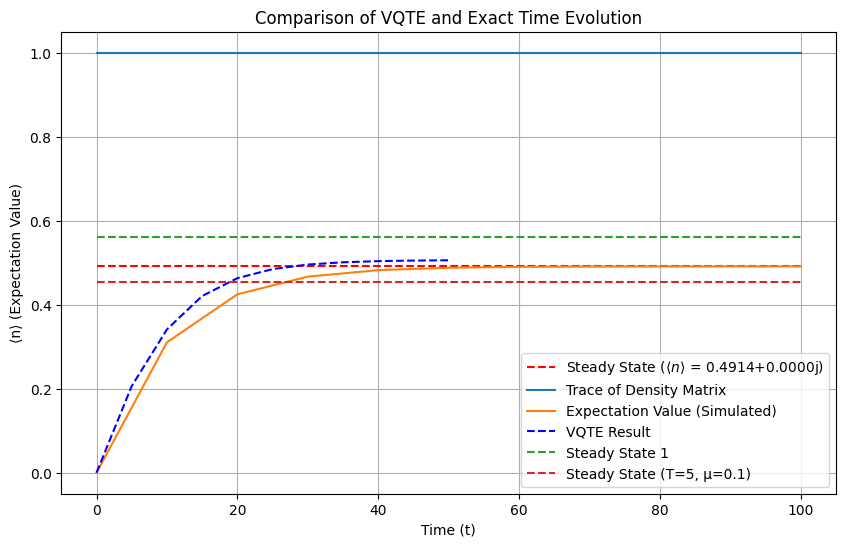

In [3]:
main()